In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    #conversion from a rgb to grayscale based on brightness
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #for reducing the noise and smoothening of image size in (5,5) standard deviation 0 as a extent of blurring 
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    #grayscale image into a binary image, where each pixel is either white (object) or black (background)
    #In this case, the threshold() function takes four arguments: the blurred grayscale image (gray),
    #the threshold value (45), the maximum value to be assigned to pixels above the threshold value (255),
    #and the type of thresholding operation to be performed (cv2.THRESH_BINARY).
    #The cv2.THRESH_BINARY argument specifies that a binary thresholding operation should be performed.
    #This means that pixels with intensity values above the threshold value are set to the maximum value (255) 
    #and pixels with intensity values below the threshold value are set to 0. The [1] 
    #at the end of the line is used to extract the second element of the output tuple returned by 
    #the threshold() function, which is the thresholded image.
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    
    # THREE ARG thresh as image , none default argument as 3*3 rectanguler matrix 
    #Erosion is a morphological operation used to remove small objects or noise from an image by shrinking the boundaries of
    #foreground objects
    thresh = cv2.erode(thresh, None, iterations=2)
    
    # THREE ARG thresh as image , none default argument as 3*3 rectanguler matrix 
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    #The cv2.RETR_EXTERNAL argument specifies that only the external contours of objects should be retrieved, 
    #which means that any contours inside an object will not be detected.
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    cnts = imutils.grab_contours(cnts)
    
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

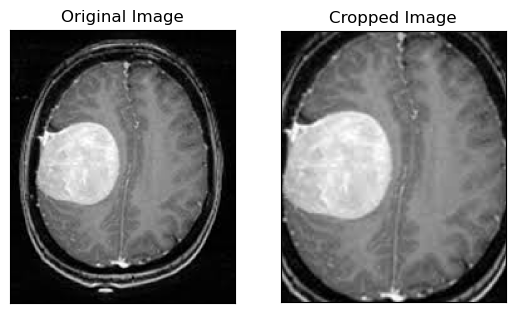

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes1' 
augmented_no = augmented_path + 'no1'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

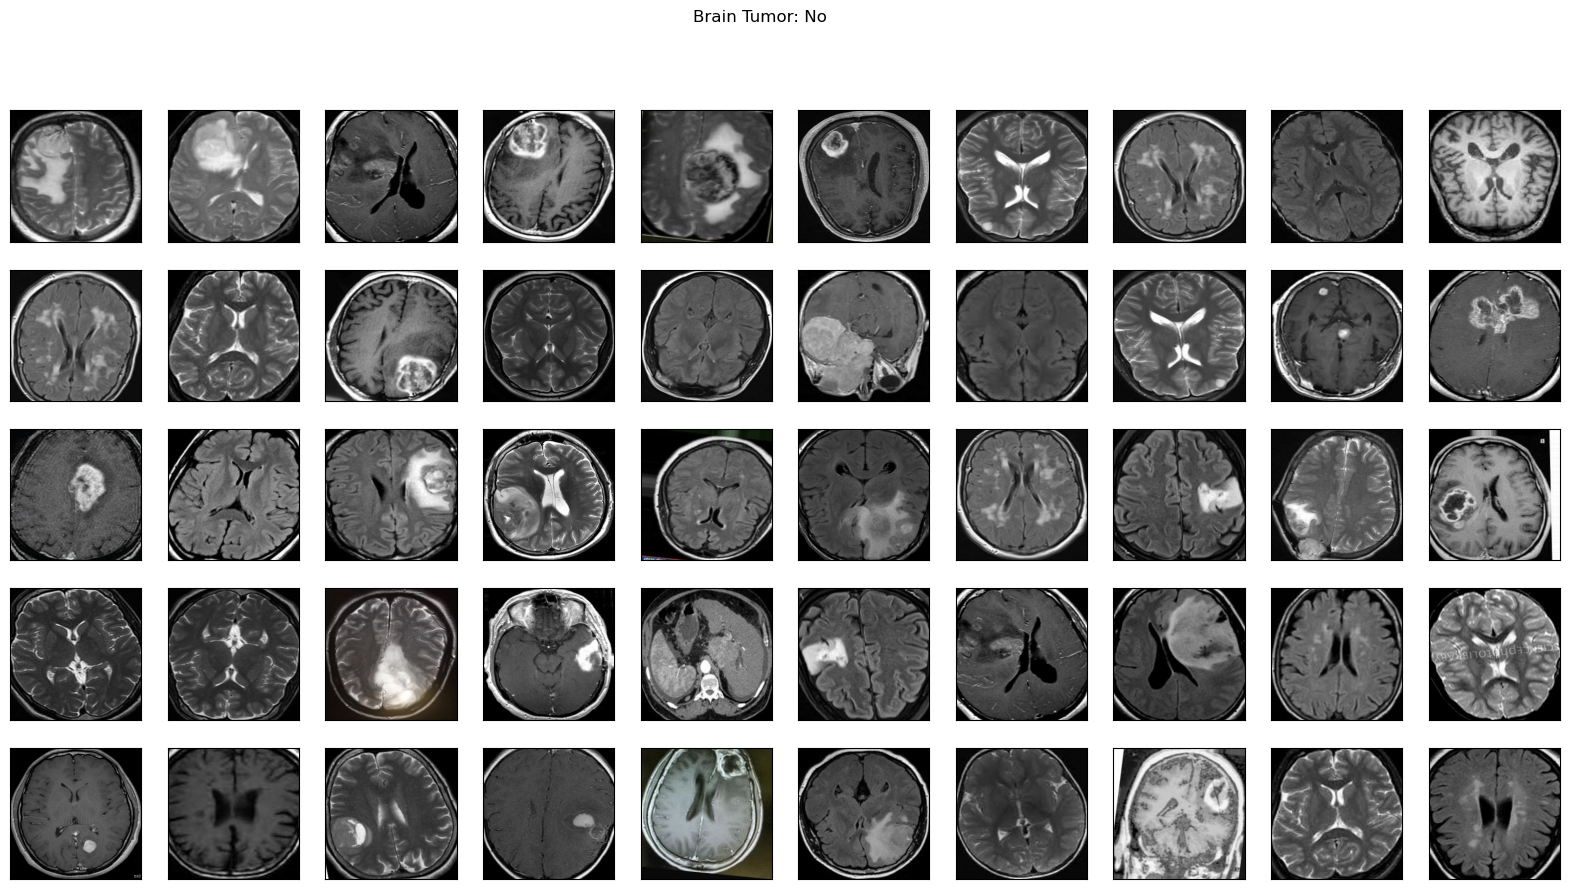

<Figure size 2000x1000 with 0 Axes>

In [7]:
plot_sample_images(X, y)

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. is in keras 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
#filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
#checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [20]:
filepath="models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9785
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to models\cnn-parameters-improvement-01-1.00


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-1.00\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-1.00\assets


46/46 [==============================] - 59s 1s/step - loss: 0.0405 - accuracy: 0.9785 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 1.1281e-10 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
46/46 [==============================] - 53s 1s/step - loss: 1.1281e-10 - accuracy: 1.0000 - val_loss: 7.9858e-04 - val_accuracy: 1.0000
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 1.1951e-10 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
46/46 [==============================] - 56s 1s/step - loss: 1.1951e-10 - accuracy: 1.0000 - val_loss: 4.5491e-04 - val_accuracy: 1.0000
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 1.1737e-10 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.00000
46/46 [==============================] - 54s 1s/step - loss: 1.1737e-10 - accuracy: 1.0000 - val_loss: 1.8825e-04 - val_accuracy: 1.0000
Epoch 5/10
46

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 1.2350e-10 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
46/46 [==============================] - 62s 1s/step - loss: 1.2350e-10 - accuracy: 1.0000 - val_loss: 9.8308e-09 - val_accuracy: 1.0000
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 1.2092e-10 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
46/46 [==============================] - 54s 1s/step - loss: 1.2092e-10 - accuracy: 1.0000 - val_loss: 3.2062e-09 - val_accuracy: 1.0000
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 1.2002e-10 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
46/46 [==============================] - 54s 1s/step - loss: 1.2002e-10 - accuracy: 1.0000 - val_loss: 1.3207e-09 - val_accuracy: 1.0000
Elapsed time: 0:2:57.8


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 1.3857e-10 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
46/46 [==============================] - 57s 1s/step - loss: 1.3857e-10 - accuracy: 1.0000 - val_loss: 6.6490e-10 - val_accuracy: 1.0000
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 1.3493e-10 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
46/46 [==============================] - 53s 1s/step - loss: 1.3493e-10 - accuracy: 1.0000 - val_loss: 4.0397e-10 - val_accuracy: 1.0000
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 1.0528e-10 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
46/46 [==============================] - 53s 1s/step - loss: 1.0528e-10 - accuracy: 1.0000 - val_loss: 2.7335e-10 - val_accuracy: 1.0000
Elapsed time: 0:2:48.4


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 1.4617e-10 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
46/46 [==============================] - 62s 1s/step - loss: 1.4617e-10 - accuracy: 1.0000 - val_loss: 2.1431e-10 - val_accuracy: 1.0000
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 1.2556e-10 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
46/46 [==============================] - 56s 1s/step - loss: 1.2556e-10 - accuracy: 1.0000 - val_loss: 1.8146e-10 - val_accuracy: 1.0000
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 1.2303e-10 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
46/46 [==============================] - 62s 1s/step - loss: 1.2303e-10 - accuracy: 1.0000 - val_loss: 1.6281e-10 - val_accuracy: 1.0000
Elapsed time: 0:3:5.1


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 [==============================] - ETA: 0s - loss: 1.0781e-10 - accuracy: 1.0000
Epoch 1: val_accuracy did not improve from 1.00000
46/46 [==============================] - 66s 1s/step - loss: 1.0781e-10 - accuracy: 1.0000 - val_loss: 1.5394e-10 - val_accuracy: 1.0000
Epoch 2/5
46/46 [==============================] - ETA: 0s - loss: 1.1180e-10 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
46/46 [==============================] - 63s 1s/step - loss: 1.1180e-10 - accuracy: 1.0000 - val_loss: 1.4581e-10 - val_accuracy: 1.0000
Epoch 3/5
46/46 [==============================] - ETA: 0s - loss: 1.2255e-10 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
46/46 [==============================] - 63s 1s/step - loss: 1.2255e-10 - accuracy: 1.0000 - val_loss: 1.4025e-10 - val_accuracy: 1.0000
Epoch 4/5
46/46 [==============================] - ETA: 0s - loss: 1.3746e-10 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 1.000

In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

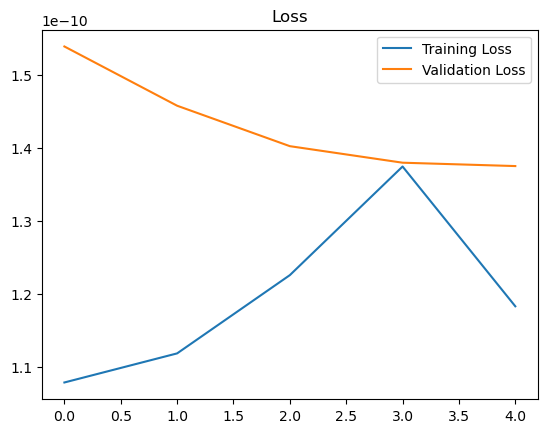

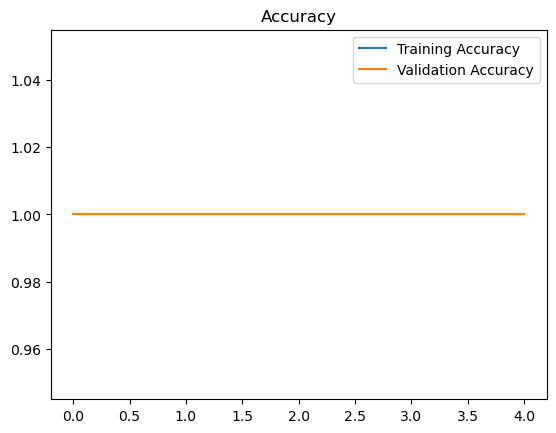

In [29]:
plot_metrics(history) 

In [30]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [31]:
best_model.metrics_names

['loss', 'accuracy']

In [32]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 3s 300ms/step - loss: 2.1148 - accuracy: 0.5129


In [33]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 2.114804744720459
Test Accuracy = 0.5129032135009766


In [34]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 3s 295ms/step


In [35]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.0


In [36]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 3s 313ms/step


In [37]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.0


In [38]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [39]:
# the whole data
data_percentage(y)

Number of examples: 2064
Percentage of positive examples: 0.0%, number of pos examples: 0
Percentage of negative examples: 100.0%, number of neg examples: 2064


In [40]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1444
Percentage of positive examples: 0.0%, number of pos examples: 0
Percentage of negative examples: 100.0%, number of neg examples: 1444
Validation Data:
Number of examples: 310
Percentage of positive examples: 0.0%, number of pos examples: 0
Percentage of negative examples: 100.0%, number of neg examples: 310
Testing Data:
Number of examples: 310
Percentage of positive examples: 0.0%, number of pos examples: 0
Percentage of negative examples: 100.0%, number of neg examples: 310
